### Classificação Multi-Label de Gêneros de Filmes com Base nas Sinopses
### ------------------------------------------------------------------------------

### Este notebook foi criado por Arthur de Moura Mota. [LinkedIn](https://www.linkedin.com/in/arthur-de-moura-mota/).

### ------------------------------------------------------------------------------
### Este notebook realiza:
### 1. Leitura e análise exploratória dos dados
### 2. Pré-processamento do texto das sinopses
### 3. Treinamento de um modelo de classificação multi-label
### 4. Avaliação do modelo
### 5. Implementação de um pipeline para predição

### -----------------------------------------
### 1. Importação das Bibliotecas Necessárias

In [53]:
pip install pandas scikit-learn matplotlib seaborn nltk tqdm ipywidgets


   ---------------------------------------- 0.0/139.8 kB ? eta -:--:--
   -- ------------------------------------- 10.2/139.8 kB ? eta -:--:--
   -------- ------------------------------ 30.7/139.8 kB 435.7 kB/s eta 0:00:01
   ----------------- --------------------- 61.4/139.8 kB 544.7 kB/s eta 0:00:01
   -------------------------------------- - 133.1/139.8 kB 1.1 MB/s eta 0:00:01
   -------------------------------------- 139.8/139.8 kB 918.6 kB/s eta 0:00:00
   ---------------------------------------- 0.0/214.4 kB ? eta -:--:--
   -------------------------------------- - 204.8/214.4 kB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 214.4/214.4 kB 4.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   -------- ------------------------------- 0.5/2.3 MB 16.5 MB/s eta 0:00:01
   -------------------- ------------------- 1.2/2.3 MB 15.4 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 18.6 MB/s eta 0:00:00
Note: 


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import json
import random
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer

# Configuração para exibir todas as colunas do DataFrame
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, jaccard_score, roc_auc_score, average_precision_score, log_loss, accuracy_score


import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords

from nltk.stem import PorterStemmer
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from tqdm import tqdm
tqdm.pandas(dynamic_ncols=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arthu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\arthu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\arthu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### ------------------------------------------------------------------------------
### 2. Carregamento dos Dados e Limpeza inicial

In [6]:
# Carregar os dados
metadata = pd.read_csv('movie.metadata.tsv', sep='\t', header=None, names=[
    'movie_id', 'freebase_movie_id', 'title', 'release_date', 'box_office', 'runtime',
    'languages', 'countries', 'genres'
])
plot_summaries = pd.read_csv('plot_summaries.txt', sep='\t', header=None, names=['movie_id', 'summary'])

In [9]:
# Limpeza dos gêneros
metadata['genres_str'] = metadata['genres'].apply(lambda x: ', '.join(x) if isinstance(x, list) else '')

#Realizando o merge com 'left' para manter todos os filmes de 'metadata'
data = pd.merge(metadata[['movie_id','title','genres']],plot_summaries, on='movie_id')
data['genres']= data['genres'].astype(str)
data['genres'] = data['genres'].apply(lambda x: list(json.loads(x).values()))
print(data.shape)

(42204, 4)


Foi realizada a limpeza da coluna de gêneros, convertendo listas de gêneros em strings. Em seguida, foi feito um merge entre as tabelas metadata e plot_summaries para combinar informações dos filmes, mantendo todos os filmes de metadata. 
Por fim, a coluna de gêneros foi processada para voltar a ser uma lista de gêneros.
O resultado foi uma tabela unificada com as informações dos filmes.

Resultado: O DataFrame data foi gerado com as colunas movie_id, title e genres

### ------------------------------------------------------------------------------
### 3. Análise Exploratória dos Dados e Limpeza

In [51]:
# Analisando o resultado
print(f"\nNúmero de filmes após o merge: {data.shape[0]}")
print(f"Contagem de valores nulos em 'summary' após o merge: {data['summary'].isnull().sum()}")

# 1. Análise Exploratória Inicial dos Dados

# Informações gerais e valores ausentes
print("Informações de metadata:")
print(metadata.info())
print(metadata.describe())
print(metadata.head())
print("\nInformações de plot_summaries:")
print(plot_summaries.info())
print(plot_summaries.describe())
print(plot_summaries.head())




Número de filmes após o merge: 41538
Contagem de valores nulos em 'summary' após o merge: 0
Informações de metadata:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81741 entries, 0 to 81740
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           81741 non-null  int64  
 1   freebase_movie_id  81741 non-null  object 
 2   title              81741 non-null  object 
 3   release_date       74839 non-null  object 
 4   box_office         8401 non-null   float64
 5   runtime            61291 non-null  float64
 6   languages          81741 non-null  object 
 7   countries          81741 non-null  object 
 8   genres             81741 non-null  object 
 9   genres_str         81741 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 6.2+ MB
None
           movie_id    box_office       runtime
count  8.174100e+04  8.401000e+03  6.129100e+04
mean   1.740784e+07  4.799363e+07 

Foi realizado um exame preliminar dos dados após o merge entre metadata e plot_summaries. O número de filmes foi de 42.204, e não houve valores nulos na coluna summary. Foram exibidas informações gerais sobre as tabelas metadata e plot_summaries, incluindo o número de entradas, tipos de dados e algumas estatísticas descritivas.

Resultado: As informações sobre os filmes e as sinopses estão completas, sem valores ausentes.

In [29]:

# Gêneros mais frequentes após merge
all_genres_after_merge = [genre for sublist in data['genres'] for genre in sublist]

genre_frequency_after_merge = pd.Series(all_genres_after_merge).value_counts()

print("\nFrequência dos Gêneros dos Filmes Após Junção:")
print(genre_frequency_after_merge)



Frequência dos Gêneros dos Filmes Após Junção:
Drama                   19134
Comedy                  10467
Romance Film             6666
Thriller                 6530
Action                   5868
                        ...  
Children's Issues           1
Political Documetary        1
Linguistics                 1
C-Movie                     1
Homoeroticism               1
Name: count, Length: 362, dtype: int64


In [ ]:
Foi realizada uma análise sobre os gêneros mais frequentes após o merge dos dados. 
A partir da lista de gêneros dos filmes, foi gerada uma contagem de cada gênero, evidenciando a prevalência dos gêneros mais comuns,
como "Drama", "Comedy" e "Romance Film", além da presença de muitos gêneros menos frequentes.

In [17]:
# Verificando valores nulos
metadata_nulls = metadata.isnull().sum()
plot_summaries_nulls = plot_summaries.isnull().sum()

print(f'\nValores nulos nos dados de metadata:\n{metadata_nulls}')
print(f'\nValores nulos nos dados de plot_summaries:\n{plot_summaries_nulls}')

# Verificando duplicatas
metadata_duplicates = metadata.duplicated(subset=['movie_id', 'genres_str']).sum()
plot_summaries_duplicates = plot_summaries.duplicated().sum()

print(f'\nDuplicatas nos dados de metadata: {metadata_duplicates}')
print(f'\nDuplicatas nos dados de plot_summaries: {plot_summaries_duplicates}')







Valores nulos nos dados de metadata:
movie_id                 0
freebase_movie_id        0
title                    0
release_date          6902
box_office           73340
runtime              20450
languages                0
countries                0
genres                   0
genres_str               0
dtype: int64

Valores nulos nos dados de plot_summaries:
movie_id    0
summary     0
dtype: int64

Duplicatas nos dados de metadata: 0

Duplicatas nos dados de plot_summaries: 0


Foi realizada uma verificação nos dados para identificar valores nulos e duplicatas.

    Valores nulos:

        O conjunto de dados metadata apresenta valores nulos em algumas colunas como release_date, box_office e runtime.

        O conjunto plot_summaries não apresenta valores nulos, garantindo que todas as sinopses estão completas.

    Duplicatas:

        Não foram encontradas duplicatas nos dados de metadata e plot_summaries, garantindo a integridade dos registros.

In [18]:
# Análise de Consistência de 'movie_id' entre os DataFrames

# Verificar se todos os movie_id de metadata estão em plot_summaries
metadata_not_in_plots = metadata[~metadata['movie_id'].isin(plot_summaries['movie_id'])]
# Verificar se todos os movie_id de plot_summaries estão em metadata
plots_not_in_metadata = plot_summaries[~plot_summaries['movie_id'].isin(metadata['movie_id'])]

# Exibir as análises
print(f"\nNúmero de filmes em 'metadata' que não possuem resumo em 'plot_summaries': {metadata_not_in_plots.shape[0]}")
print(f"Número de filmes em 'plot_summaries' que não possuem entrada em 'metadata': {plots_not_in_metadata.shape[0]}")

# Exibir alguns exemplos de filmes que não possuem correspondência
print("\nExemplos de filmes em 'metadata' sem resumo:")
print(metadata_not_in_plots[['movie_id', 'title']].head())

print("\nExemplos de filmes em 'plot_summaries' sem dados de 'metadata':")
print(plots_not_in_metadata[['movie_id', 'summary']].head())


Número de filmes em 'metadata' que não possuem resumo em 'plot_summaries': 39537
Número de filmes em 'plot_summaries' que não possuem entrada em 'metadata': 99

Exemplos de filmes em 'metadata' sem resumo:
   movie_id                                              title
1   3196793  Getting Away with Murder: The JonBenét Ramsey ...
2  28463795                                        Brun bitter
5  13696889                                      The Gangsters
7  10408933                           Alexander's Ragtime Band
8   9997961                                     Contigo y aquí

Exemplos de filmes em 'plot_summaries' sem dados de 'metadata':
      movie_id                                            summary
231    2862137  Sathyanarayan Murthy  is a rough but kind man ...
540   33334420  {{more plot}} Mural tells the story of Zhu Xia...
1071  16758721  The story is about a young man “Tony”, a 25 ye...
1449  23217064   Years before the events of the first film, Lo...
2083   2746943  A yo

Foi realizada uma análise para verificar a consistência dos movie_id entre os DataFrames metadata e plot_summaries.

    Filmes em 'metadata' sem resumo: Existem 39.537 filmes em metadata que não possuem correspondência no plot_summaries, ou seja, não têm uma sinopse associada.

    Filmes em 'plot_summaries' sem entrada em 'metadata': Existem 99 filmes em plot_summaries sem entrada correspondente em metadata.

Exemplos de Filmes sem Resumo em plot_summaries:

    Filmes como "Getting Away with Murder: The JonBenét Ramsey" e "Brun bitter" não têm sinopse associada.

Exemplos de Filmes sem Entrada em metadata:

    Filmes como "Sathyanarayan Murthy" e "Mural" não têm dados correspondentes em metadata.

Essa análise indica que há filmes em metadata sem resumo e alguns filmes com sinopse mas sem informações no metadata.

In [23]:
# 2. Distribuição do Número de Gêneros por Filme
genre_counts = data['genres'].apply(lambda x: len(x)).value_counts()

print("\nDistribuição do número de gêneros por filme:")
for num_genres, count in genre_counts.items():
    print(f"{num_genres} gênero(s): {count} filmes")



Distribuição do número de gêneros por filme:
1 gênero(s): 8424 filmes
2 gênero(s): 7440 filmes
3 gênero(s): 7053 filmes
4 gênero(s): 6211 filmes
5 gênero(s): 4497 filmes
6 gênero(s): 3326 filmes
7 gênero(s): 2222 filmes
8 gênero(s): 1249 filmes
9 gênero(s): 725 filmes
0 gênero(s): 411 filmes
10 gênero(s): 356 filmes
11 gênero(s): 166 filmes
12 gênero(s): 70 filmes
13 gênero(s): 36 filmes
14 gênero(s): 11 filmes
15 gênero(s): 5 filmes
16 gênero(s): 1 filmes
17 gênero(s): 1 filmes


    A maioria dos filmes tem 1 ou 2 gêneros:

        1 gênero: 8.424 filmes

        2 gêneros: 7.440 filmes

    Há filmes com até 16 gêneros, mas em menor quantidade:

        16 gêneros: 1 filme

    Apenas 411 filmes não têm gêneros atribuídos.

Isso mostra que a maioria dos filmes tem entre 1 a 5 gêneros

Drama           19134
Comedy          10467
Romance Film     6666
Thriller         6530
Action           5868
Name: count, dtype: int64
Mediana: 42.00
Q1 (25%): 7.00
Percentil 80% (Q80): 266.40
Média (μ): 415.36
Desvio Padrão (σ): 1429.63
Limite Mínimo (μ - σ): 266.40

Frequência do Top  Gêneros dos Filmes Após Filtro:
Drama                 19134
Comedy                10467
Romance Film           6666
Thriller               6530
Action                 5868
                      ...  
Buddy film              325
Anime                   305
Historical fiction      305
Detective               282
Road movie              268
Name: count, Length: 73, dtype: int64

Número de gêneros antes: 363
Número de gêneros após filtro: 73


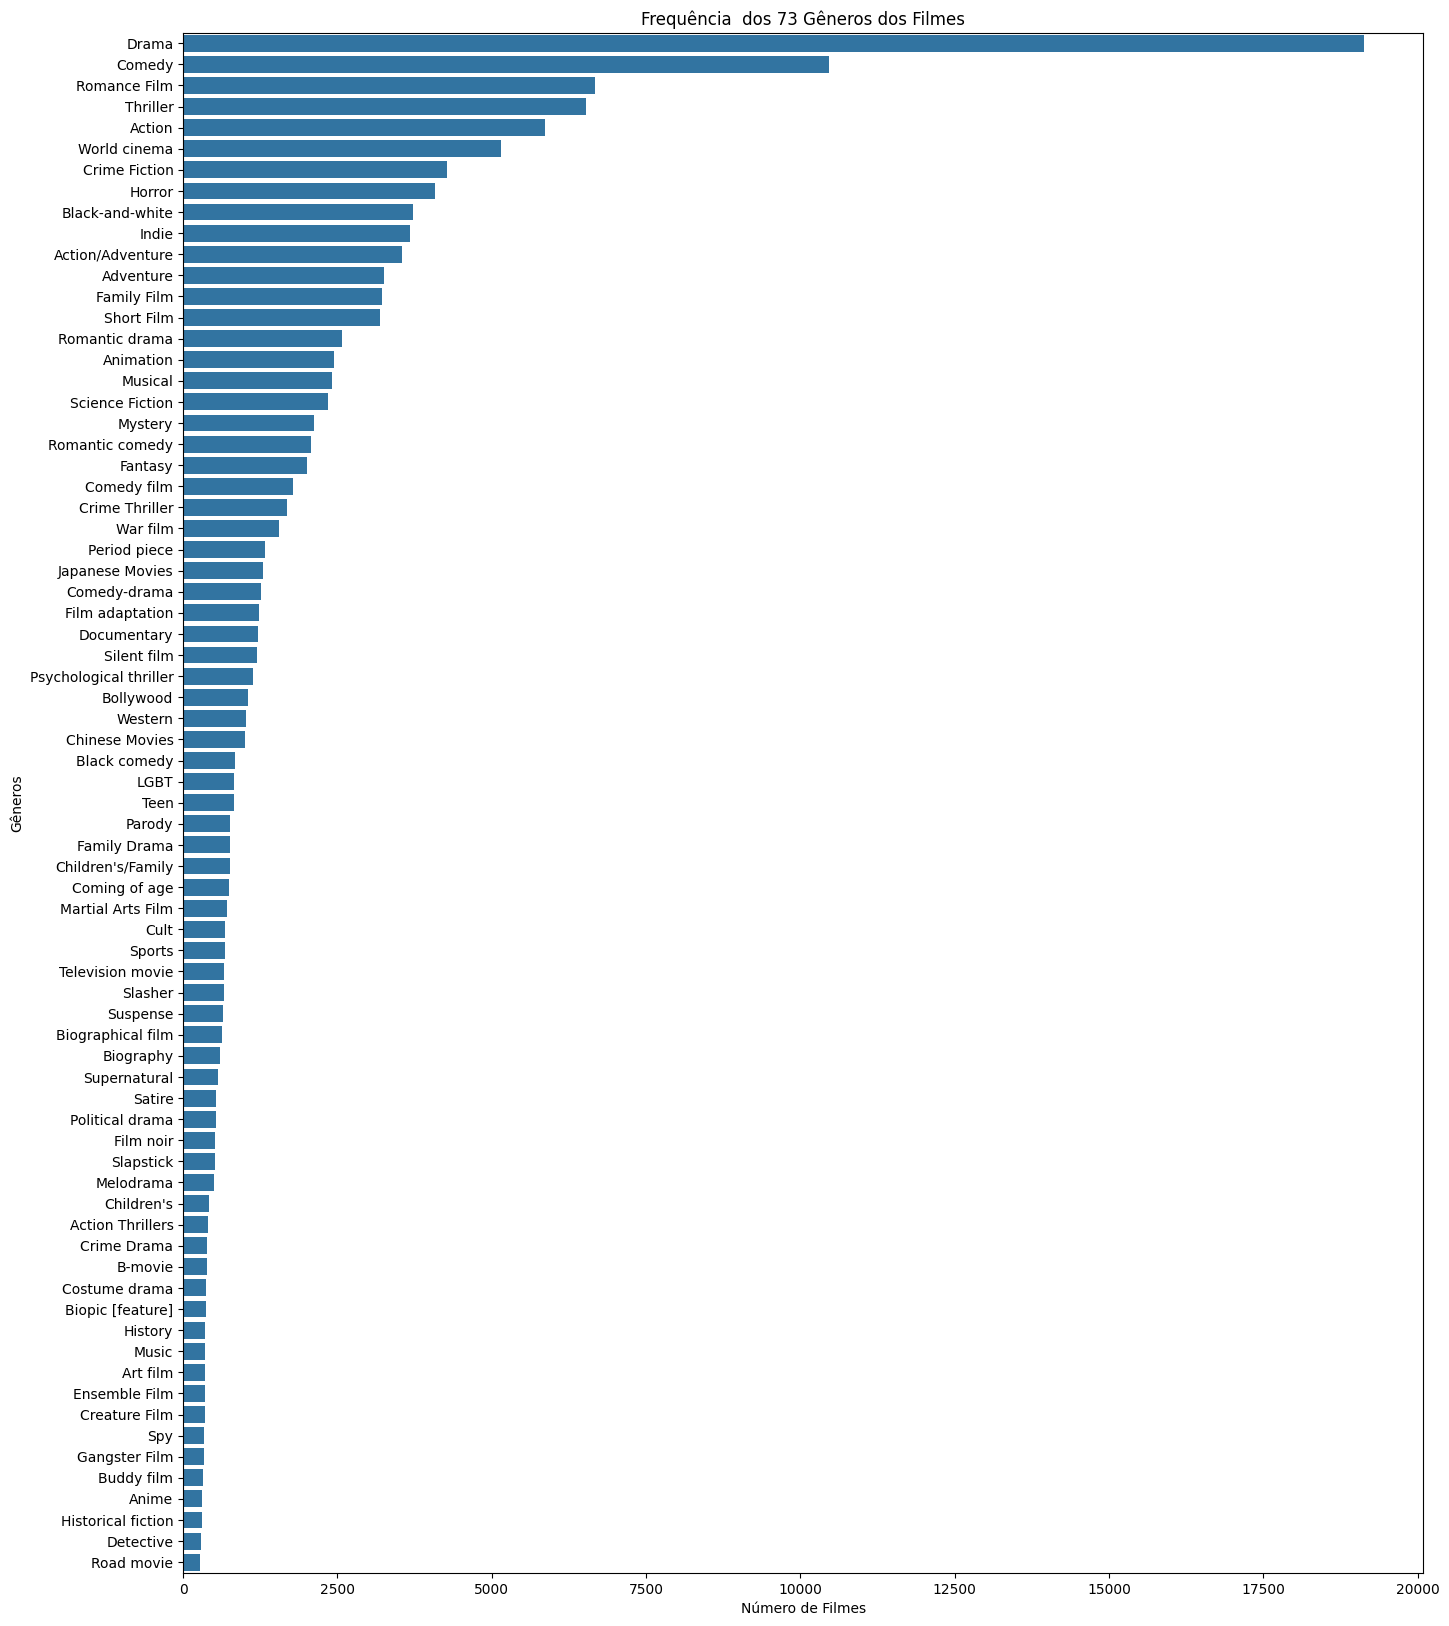

In [24]:
# 3. Frequência dos Gêneros
all_genres = [genre for sublist in data['genres'] for genre in sublist]
genre_frequency = pd.Series(all_genres).value_counts()

print(genre_frequency.head())

# Estatísticas básicas
media = genre_frequency.mean()
desvio_padrao = genre_frequency.std()

# Estatísticas robustas
mediana = genre_frequency.median()
q1 = genre_frequency.quantile(0.25)

# Exibir estatísticas para depuração
print(f"Mediana: {mediana:.2f}")
print(f"Q1 (25%): {q1:.2f}")

# Calcula o Percentil 80% (Q80)
q80 = genre_frequency.quantile(0.80)
print(f"Percentil 80% (Q80): {q80:.2f}")

# Define o limite mínimo 
limite_minimo = q80

print(f"Média (μ): {media:.2f}")
print(f"Desvio Padrão (σ): {desvio_padrao:.2f}")
print(f"Limite Mínimo (μ - σ): {limite_minimo:.2f}")

# Filtrar gêneros acima do limite
genre_filtered = genre_frequency[genre_frequency >= limite_minimo]

print(f"\nFrequência do Top   Gêneros dos Filmes Após Filtro:")
print(genre_filtered)

# Número total de gêneros antes e depois do filtro
print(f"\nNúmero de gêneros antes: {len(genre_frequency)}")
print(f"Número de gêneros após filtro: {len(genre_filtered)}")

plt.figure(figsize=(16, 20))
sns.barplot(x=genre_filtered.values, y=genre_filtered.index, orient='h')
plt.title(f'Frequência  dos {len(genre_filtered)} Gêneros dos Filmes')
plt.xlabel('Número de Filmes')
plt.ylabel('Gêneros')
plt.show()

In [25]:
# Converter a lista de gêneros filtrados para um conjunto (mais eficiente para buscas)
filtered_genres_set = set(genre_filtered.index)
# Exibir quantos filmes restaram após o filtro
print(f"Número de filmes antes: {len(data)}")
# Filtrar DataFrame: manter apenas os filmes com pelo menos um gênero aceito
data = data[data['genres'].apply(lambda genres: any(g in filtered_genres_set for g in genres))]
print(f"Número de filmes após filtro: {len(data)}")

Número de filmes antes: 42204
Número de filmes após filtro: 41538


Após aplicar o filtro com base no limite mínimo de 266 filmes, obteve-se 73 gêneros mais frequentes (em vez de 363 no total), destacando os gêneros com maior relevância no conjunto de dados.
Ao removermos os menos frequêntes, o data set não sofre muito impacto. Essa ação tem o intuito de diminuir o numero de labels e melhorar a eficiência do modelo.



Distribuição do Número de Gêneros por Filme Após Junção:
genres
1     8216
2     7407
3     7045
4     6208
5     4497
6     3324
7     2221
8     1249
9      725
10     356
11     166
12      70
13      36
14      11
15       5
16       1
17       1
Name: count, dtype: int64

Distribuição do Número de Gêneros por Filme Após redução menos frequentes:
genres
1     8216
2     7407
3     7045
4     6208
5     4497
6     3324
7     2221
8     1249
9      725
10     356
11     166
12      70
13      36
14      11
15       5
16       1
17       1
Name: count, dtype: int64


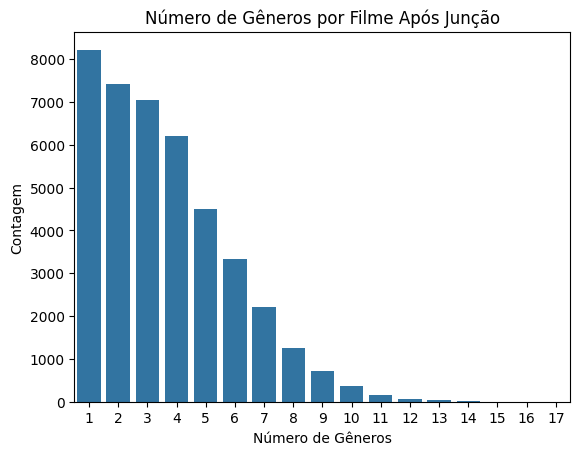

In [27]:
# 7. Análise Final Após Merge / Verificação de Desequilíbrio de Classe
# Contando o número de gêneros por filme (agora que 'genres' é uma lista)
genre_counts_after_merge = data['genres'].apply(lambda x: len(x)).value_counts()

# Exibindo a distribuição do número de gêneros por filme
print("\nDistribuição do Número de Gêneros por Filme Após Junção:")
print(genre_counts_after_merge)


# Exibindo a distribuição do número de gêneros por filme
print("\nDistribuição do Número de Gêneros por Filme Após redução menos frequentes:")
print(genre_counts_after_merge)




# # Plotando o gráfico
sns.barplot(x=genre_counts_after_merge.index, y=genre_counts_after_merge.values)
plt.title('Número de Gêneros por Filme Após Junção')
plt.xlabel('Número de Gêneros')
plt.ylabel('Contagem')
plt.show()

count    41538.000000
mean       312.199408
std        318.752287
min          4.000000
25%         87.000000
50%        188.000000
75%        457.000000
max       4929.000000
Name: summary_length, dtype: float64


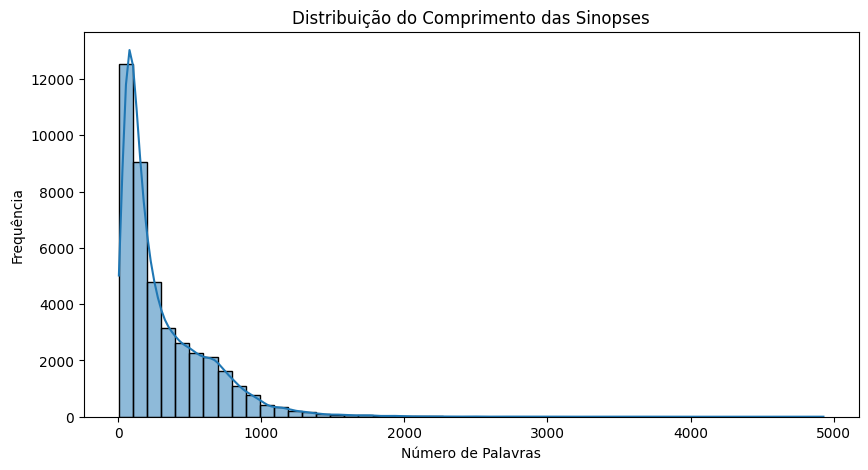

In [31]:
#Distribuição do Comprimento das Sinopses
data['summary_length'] = data['summary'].apply(lambda x: len(x.split()))
print(data['summary_length'].describe())

plt.figure(figsize=(10, 5))
sns.histplot(data['summary_length'], bins=50, kde=True)
plt.title('Distribuição do Comprimento das Sinopses')
plt.xlabel('Número de Palavras')
plt.ylabel('Frequência')
plt.show()

Esses valores indicam uma grande variação no comprimento das sinopses, com algumas extremamente curtas e outras bastante longas, o que pode influenciar na análise e no pré-processamento para modelos de machine learning.


### 4. Pré-processamento das Sinopses

In [39]:
# Definir stopwords
stop_words = set(stopwords.words('english'))

# Objetivo: Remover ruído textual para melhorar a eficiência dos modelos.
def preprocess_text(text):
    text = text.lower()  # Converte para minúsculas

    text = re.sub(r'\W', ' ', text)  # Remove caracteres especiais
    text = re.sub(r'\s+', ' ', text).strip()  # Remove espaços extras
    text = text.split()
    # Remove stopwords e retorna apenas as palavras significativas
    text = [word for word in text if word not in stop_words]
    return ' '.join(text)

In [40]:
# Aplicar o pré-processamento com barra de progresso

data['summary_clean'] = data['summary'].progress_apply(preprocess_text)

print("preprocess_text(text) ok")

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41538/41538 [00:12<00:00, 3365.17it/s]

preprocess_text(text) ok


In [42]:
ps = PorterStemmer()

def  plot_stemming(text):
    text = text.split()
    text = [ps.stem(word) for word in text]
    text = ' '.join(text)
    return text

data['summary_clean'] = data['summary_clean'].progress_apply(plot_stemming)
print("plot_stemming ok")

print(data.head())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41538/41538 [02:22<00:00, 291.86it/s]

plot_stemming ok
   movie_id                      title                                             genres                                            summary  summary_length                                      summary_clean
0    975900             Ghosts of Mars  [Thriller, Science Fiction, Horror, Adventure,...  Set in the second half of the 22nd century, th...             357  set second half 22nd centuri film depict mar p...
1   9363483           White Of The Eye  [Thriller, Erotic thriller, Psychological thri...  A series of murders of rich young women throug...             590  seri murder rich young women throughout arizon...
2    261236          A Woman in Flames                                            [Drama]  Eva, an upper class housewife, becomes frustra...             426  eva upper class housewif becom frustrat leav a...
3  18998739  The Sorcerer's Apprentice    [Family Film, Fantasy, Adventure, World cinema]  Every hundred years, the evil Morgana  returns...           

In [43]:
# Selecionar uma linha aleatória para verificação
random_row = random.choice(range(len(data)))
print(f"Gêneros: {data['genres'].iloc[random_row]}")
print("Exemplo Texto Original:\n", data['summary'].iloc[random_row])
print("\nExemplo Texto Pós-Limpeza:\n", data['summary_clean'].iloc[random_row])

Gêneros: ['Drama']
Exemplo Texto Original:
 7 Hati follows the story of seven women who are unknowingly interconnected. The lead character, Kartini , is a 45-year-old obstetrician who finds herself increasingly sympathetic with her patients. These patients include Ratna , a hijab-wearing woman who is pregnant for the first time; Rara , Ratna's 14-year-old sister; Yanti , a prostitute; Lili , a pregnant Chinese Indonesian woman; and Lastri , an obese woman. Each character has their own problems, which they confide to Kartini about. Ratna is overworked and has to support her family, without the help of her materialistic husband. Rara is worried that she may be pregnant after having sexual intercourse with her boyfriend. Yanti suffers from cervical cancer. Lili has been sexually abused by her husband, but thinks of it as an indication of his love. Lastri is newly-married and trying to get pregnant. Kartini herself has had bad experiences in her former relationships, making her afraid of c

In [44]:
# Binarizar os gêneros (transformar rótulos multilabel em binário)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(data['genres'])  # Separando os gêneros
X = data['summary_clean']

print("Labels binarizados para classificação multirrótulo.")
print(y)

Labels binarizados para classificação multirrótulo.
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


A binarização dos gêneros é necessária para transformar os rótulos multilabel (vários gêneros por filme) em uma representação binária,
onde cada gênero é tratado como uma variável independente.
Isso permite que o modelo de classificação multi-label consiga aprender a identificar a presença ou
ausência de cada gênero para uma sinopse de filme, facilitando a predição dos múltiplos gêneros de forma eficiente.

### 5. Vetorização e Separação dos Dados

In [45]:
X_train, X_test,y_train,y_test = train_test_split(X,y, test_size =0.50, random_state = 42)

# Vetorização TF-IDF com 5000 palavras mais frequentes e max_df=0.8
tfidf_vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8)
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)

print("Transformação TF-IDF concluída.")

Transformação TF-IDF concluída.


### 6. Treinamento do Modelo

In [47]:
# Criando o modelo OneVsRestClassifier com LogisticRegression
model = OneVsRestClassifier(LogisticRegression(C=0.5, class_weight='balanced', dual=False, fit_intercept=True,
                                                         intercept_scaling=10, max_iter=150,
                                                         penalty='l2', random_state=None, solver='liblinear', tol=1e-4,
                                                         verbose=1))

model.fit(X_train,y_train)
y_pred_model = model.predict(X_test)

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 36 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 48 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 55 is present in all training examples.
  warnings.warn(
C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 56 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 74 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 132 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 200 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 210 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 214 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 241 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 268 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 306 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 341 is present in all training examples.
  warnings.warn(


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\multiclass.py:90: UserWarning: Label not 360 is present in all training examples.
  warnings.warn(


[LibLinear]

Após algumas tentativas, constatou-se que estes eram os melhores hiperparâmetros até então.
Por falta de recursos computacionais e tempo, não foi possível executar com qualidade tecnicas como GridSearch e validação cruzada para melhorar a perfomance.

### ------------------------------------------------------------------------------
### 7. Avaliação do Modelo

In [48]:
# Avaliação das métricas

print("F1 Micro: ", f1_score(y_test, y_pred_model, average='micro'))
print("F1 Macro: ", f1_score(y_test, y_pred_model, average='macro'))
print("Precision per label: ", precision_score(y_test, y_pred_model, average=None))
print("Recall per label: ", recall_score(y_test, y_pred_model, average=None))
print("Hamming Loss: ", hamming_loss(y_test, y_pred_model))
print("Jaccard Similarity (Micro): ", jaccard_score(y_test, y_pred_model, average='micro'))
print("Jaccard Similarity (Macro): ", jaccard_score(y_test, y_pred_model, average='macro'))
print("Average Precision Score: ", average_precision_score(y_test, y_pred_model, average='micro'))
print("ROC AUC Score (Micro): ", roc_auc_score(y_test, y_pred_model, average='micro'))
print("ROC AUC Score (Macro): ", roc_auc_score(y_test, y_pred_model, average='macro'))
print("Log Loss: ", log_loss(y_test, y_pred_model))
print("Subset Accuracy: ", accuracy_score(y_test, y_pred_model))

0.37806013046169995
F1 Micro:  0.37806013046169995


C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


F1 Macro:  0.12954894551552215


C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Precision per label:  [0.05263158 0.         0.43159131 0.05732484 0.10438144 0.31475491
 0.02       0.06818182 0.30520548 0.10227273 0.18666667 0.
 0.15508021 0.         0.06451613 0.14356436 0.         0.04166667
 0.07792208 0.42530283 0.15869981 0.         0.         0.08163265
 0.07843137 0.         0.375      0.         0.07094134 0.25
 0.10344828 0.         0.10541311 0.         0.         0.8
 0.         0.         0.16666667 0.1129326  0.12297426 0.12244898
 0.07445008 0.28536526 0.2        0.         0.23068117 0.35135135
 0.         0.14285714 0.         0.         0.         0.
 0.06708268 0.         0.         0.         0.09243697 0.
 0.00934579 0.         0.05       0.13406293 0.         0.12895377
 0.         0.16089299 0.46941489 0.22093023 0.22413793 0.
 0.33333333 0.16352201 0.         0.48326216 0.03947368 0.08571429
 0.11961016 0.14285714 0.00740741 0.03864734 0.09077913 0.11848958
 0.         0.10144928 0.         0.         0.         0.12307692
 0.16666667 0.1646

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Recall per label:  [0.02380952 0.         0.75255973 0.11538462 0.38942308 0.71509327
 0.05263158 0.06122449 0.69021066 0.13043478 0.46666667 0.
 0.63043478 0.         0.08163265 0.42028986 0.         0.17647059
 0.36734694 0.79065888 0.55704698 0.         0.         0.28571429
 0.28571429 0.         1.         0.         0.30232558 0.68181818
 0.06976744 0.         0.37563452 0.         0.         0.5
 0.         0.         0.08333333 0.38993711 0.42574257 0.3030303
 0.32432432 0.63271939 0.16666667 0.         0.7661597  0.46428571
 0.         0.14285714 0.         0.         0.         0.
 0.2654321  0.         0.         0.         0.30555556 0.
 0.02272727 0.         0.12068966 0.46445498 0.         0.43089431
 0.         0.54145078 0.706      0.26760563 0.63414634 0.
 0.16666667 0.55319149 0.         0.67852998 0.07142857 0.09677419
 0.43926247 0.08333333 0.01       0.06722689 0.39318885 0.50980392
 0.         0.28       0.         0.         0.         0.2
 0.22580645 0.5923913  

C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Jaccard Similarity (Macro):  0.07936257209883284
Average Precision Score:  0.1708613997433204
ROC AUC Score (Micro):  0.7962585866740471


C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_ra

ROC AUC Score (Macro):  nan


C:\Users\arthu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Log Loss:  51.38854160071009
Subset Accuracy:  0.004525976214550532


A avaliação das métricas do modelo mostra que, apesar de alguma capacidade de discriminação, o desempenho ainda não é ideal para a classificação multilabel de gêneros de filmes.
Métricas Avaliadas:

    F1 Micro: 0.378
    A F1 Micro avalia a média das F1 scores em todas as classes de forma global. Esse valor sugere que o modelo tem uma capacidade limitada de distinguir corretamente os rótulos para diferentes amostras.

    F1 Macro: 0.129
    A F1 Macro considera a média das F1 scores em cada classe, sem considerar o número de amostras em cada classe. O valor baixo indica que o modelo tem um desempenho inconsistente em relação a classes menos frequentes.

    Hamming Loss: 0.020
    O Hamming Loss representa a fração de rótulos incorretos no modelo. Este valor é relativamente baixo, sugerindo que o modelo não está cometendo muitos erros graves, mas ainda assim não está perfeito.

    Jaccard Similarity (Micro e Macro)
    A Jaccard Similarity é uma boa métrica para problemas multilabel, indicando a sobreposição de rótulos preditos com os reais. A Jaccard Micro de 0.233 é razoável, mas a Macro é mais baixa, indicando que a diversidade entre as classes está prejudicada.

    Average Precision Score: 0.17
    A média da precisão das classes é também baixa, o que sugere que o modelo não está gerando muitas predições corretas para todas as classes.

    ROC AUC Score (Micro): 0.796
    O ROC AUC Micro está razoavelmente bom, indicando que o modelo é capaz de discriminar entre as classes em termos de probabilidade, mas com espaço para melhoria.

    Log Loss: 51.39
    O Log Loss é bastante alto, indicando que o modelo tem um desempenho ruim em termos de previsões probabilísticas. Isso sugere que o modelo está gerando previsões muito distantes do valor real.

    Subset Accuracy: 0.0045
    A Subset Accuracy, que avalia se todas as predições multilabel são exatas, é muito baixa, indicando que o modelo tem dificuldades em acertar todas as classes simultaneamente.

Estratégias de Melhoria:
1. Ajustes no Modelo

    Aumentar o número de iterações (max_iter): O modelo pode não estar convergindo corretamente, especialmente em problemas de alta dimensionalidade.
    Tentar aumentar o max_iter para 500 ou 1000 pode garantir que o modelo tenha tempo suficiente para convergir.

    Ajustar o valor de C: O valor de C=0.5 pode ser pequeno. Talvez valores como C=1 ou C=10 para equilibrar melhor a regularização.

2. Melhoria nos Dados

    Aumentar o conjunto de treinamento: Se possível, aumente o conjunto de dados, seja coletando mais amostras ou utilizando técnicas de data augmentation. Isso pode ajudar o modelo a aprender mais variações dos gêneros.

    Limpeza de dados: Verifique se há rótulos inconsistentes ou rótulos dominantes (como mencionado anteriormente sobre rótulos que aparecem em todas as amostras). Certifique-se de que os dados de treinamento sejam representativos.

    Pré-processamento aprimorado: Melhorar o pré-processamento de texto (como stemming, lematização, ou extração de n-gramas) pode proporcionar uma representação mais eficiente do texto.

3. Revisão da Estratégia de Balanceamento

    Uso de técnicas de resampling: Técnicas como SMOTE ou undersampling para lidar com classes desbalanceadas. (Não Houve tempo o sufiente)
4. Tuning e Validação Cruzada

    GridSearchCV ou RandomizedSearchCV: Realizar uma busca em grade de hiperparâmetros  para encontrar a melhor configuração para o modelo. (Não Houve tempo o sufiente)

    Validação cruzada: Use validação cruzada (como K-folds) para garantir que o modelo não esteja sobreajustado e tem um desempenho consistente em diferentes subconjuntos dos dados. (Não Houve tempo o sufiente)

In [49]:
print(y_pred_model[13])

print(mlb.inverse_transform( y_pred_model)[13])

[0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
('Action', 'Action/Adventure', 'Comedy Thriller', 'Costume drama', 'Crime Fiction', 'Crime Thriller', 'Detective', 'Detective fiction', 'Film adaptation', 'Mystery', 'Period piece', 'Steampunk', 'Stop motion', 'Suspense', 'Thriller')


### ------------------------------------------------------------------------------
### 8. Pipeline para Predição

In [58]:
# ------------------------------------------------------------------------------
# Pipeline para Predição

def predict_genres(summary):
    """
    Função para predizer os gêneros de um filme com base na sua sinopse.
    """
    summary_clean = preprocess_text(summary)
    summary_stemming = plot_stemming(summary_clean)
    summary_vectorized = tfidf_vectorizer.transform([summary_stemming])
    prediction = model.predict(summary_vectorized)
    return mlb.inverse_transform(prediction)[0]

# Teste com uma sinopse aleatória
random_movie = random.randint(0, len(data) - 1)
print(f"\nTítulo: {data.iloc[random_movie]['title']}")
print("Sinopse:", data.iloc[random_movie]['summary'])
print("Gêneros previstos:", predict_genres(data.iloc[random_movie]['summary']))


Título: Stratosphere Girl
Sinopse: Belgian teenager, Angela , who is skilled at drawing, meets, and subsequently falls in love, with an attractive Japanese DJ. Encouraged by him, she goes to Japan to work at an exclusive club for rich businessmen, who like to meet with young blonde women. From the start, the film is surreal with unique characters, clear and sharp cinematography, and slow panning camera work. Manga drawings are also used to enhance the plot and ambiance. Angela seeks work at the aforementioned club and, after having been begrudgingly let in, she is met with derision by the other girls working there. However, despite having spurned some of the other girls, she soon proves to be a favourite among the patrons by pretending to be a Lolita-style 15-year-old to please the businessmen. The plot has a sinister undertone of the possibility of murder of a girl, Larissa, whom Angela has replaced. As the film goes on, we learn Larissa was possibly murdered, not by Japanese men in 

## Inserir a sinopse manualmente

In [59]:
# Solicitar a sinopse manualmente
summary_input = input("Digite a sinopse do filme: ")

# Fazer a predição com a sinopse inserida
predicted_genres = predict_genres(summary_input)

# Exibir os gêneros previstos
print(f"Gêneros previstos: {predicted_genres}")

Digite a sinopse do filme:  Walter Mitty (Ben Stiller), an employee at Life magazine, spends day after monotonous day developing photos for the publication. To escape the tedium, Walter inhabits a world of exciting daydreams in which he is the undeniable hero. Walter fancies a fellow employee named Cheryl (Kristen Wiig) and would love to date her, but he feels unworthy. However, he gets a chance to have a real adventure when Life's new owners send him on a mission to obtain the perfect photo for the final print issue.


Gêneros previstos: ('Adventure', 'Comedy', 'Comedy film', 'Fantasy Comedy', 'Romance Film', 'Romantic comedy', 'Romantic drama', 'Workplace Comedy')


Conclusões Finais:

O modelo de classificação multilabel de gêneros de filmes implementado, baseado no OneVsRestClassifier com LogisticRegression, apresentou um desempenho razoável nas métricas de avaliação, mas ainda está longe de ser otimizado.